In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#This step invoves me loading the text file from the storage location on the drive
with open('/content/drive/MyDrive/gabriel_peoms_prediction/Gabriel_poems.txt') as file:
  data = file.readlines()
  corpus = ' '.join(data).lower().split('\n')            #Join Data into string,lower words and split along new lines

In [ ]:
print(len(corpus))                                     #Check Length of Data
corpus[0:20]  

366


['the call of the river nun',
 ' piano’s and drums',
 ' were i to choose',
 ' spirit of the wind',
 ' new year’s eve midnight',
 ' you laughed i laughed',
 ' the mystic drum',
 ' one night at victorias’s beach',
 ' adhiambo ',
 ' to paveba',
 ' franvenkirche',
 ' the gambler',
 ' initroit ',
 ' i hear your call! ',
 ' i hear it far away; ',
 ' i hear it break the circle of these crouching hills.',
 ' i want to view your face again and feel your cold embrace; ',
 ' or at your brim to set myself and inhale your breath; ',
 ' or like the trees, ',
 ' to watch my mirrored self unfold and span my days with song from the lips of dawn.']

In [ ]:
#The tokeninzation step is a step for data preprocessing in natural language processing
tokenizer = Tokenizer(num_words=500,oov_token="<OOV>")

tokenizer.fit_on_texts(corpus)

# Get the indices and print it
total_words = len(tokenizer.word_index) + 1
print(total_words)

744


### We are going to generate an N-gram sequence for each of the lines in the corpus and store it in a list

In [ ]:
#A corpus is simply a body of text

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

     


## 'pre' padd the sequences with '0' to make them an equal lenght array 

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))
input_sequences
     

array([[  0,   0,   0, ...,   0,   2,  30],
       [  0,   0,   0, ...,   2,  30,   5],
       [  0,   0,   0, ...,  30,   5,   2],
       ...,
       [  0,   0,   0, ...,  31, 140, 169],
       [  0,   0,   0, ...,   0,  31, 283],
       [  0,   0,   0, ...,  31, 283, 169]], dtype=int32)


### We are going to treat the word prediction as classification task where the next word in a sequence is treated as a label of the previous words. So each word is a label class.

In [ ]:
train_data = input_sequences[:,:-1]
labels = input_sequences[:,-1]
labels = tf.keras.utils.to_categorical(labels, num_classes = total_words)

## Model Trainning

In [ ]:
class myCallbacks(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:
      print("\nReached 99% accuracy so cancelling training!") 


      self.model.stop_training = True


# Instantiate the callback class
callbacks = myCallbacks()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


def create_model():

  model = tf.keras.models.Sequential([
      layer.Embedding(total_words, 64, input_length=max_sequence_len - 1),
      layer.Bidirectional((layer.LSTM(200))),
      layer.Dense(total_words, activation='softmax')
  ])


  adam = tf.keras.optimizers.Adam(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model





In [ ]:
# Get the untrained model
model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 64)            47616     
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              424000    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 744)               298344    
                                                                 
Total params: 769,960
Trainable params: 769,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data,labels,epochs=300,verbose=1,callbacks=[early_stopping])

Epoch 1/300
56/56 [==============================] - 11s 117ms/step - loss: 5.6875 - accuracy: 0.1236
Epoch 2/300
56/56 [==============================] - 7s 131ms/step - loss: 5.1362 - accuracy: 0.1157
Epoch 3/300
56/56 [==============================] - 7s 125ms/step - loss: 5.0712 - accuracy: 0.1258
Epoch 4/300
56/56 [==============================] - 7s 125ms/step - loss: 4.9995 - accuracy: 0.1230
Epoch 5/300
56/56 [==============================] - 7s 125ms/step - loss: 4.9049 - accuracy: 0.1219
Epoch 6/300
56/56 [==============================] - 7s 124ms/step - loss: 4.8208 - accuracy: 0.1349
Epoch 7/300
56/56 [==============================] - 7s 118ms/step - loss: 4.7240 - accuracy: 0.1405
Epoch 8/300
56/56 [==============================] - 6s 112ms/step - loss: 4.6072 - accuracy: 0.1608
Epoch 9/300
56/56 [==============================] - 7s 122ms/step - loss: 4.4786 - accuracy: 0.1704
Epoch 10/300
56/56 [==============================] - 7s 123ms/step - loss: 4.5307 - accur

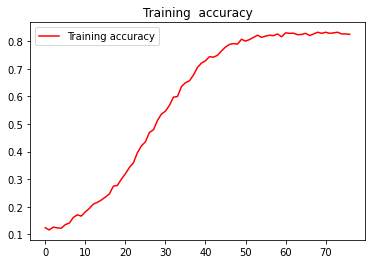

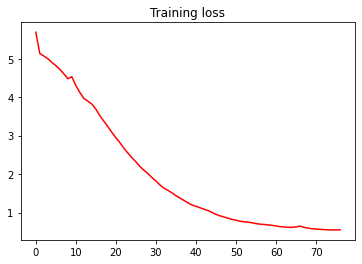

In [ ]:
# Plot the chart for accuracy and loss on training 
acc = history.history['accuracy']
loss = history.history['loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training  accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
# plt.legend()

plt.show()

## Text Prediction. A seed text to start the predicted lyrics is preprocessed exactly as the training data is

In [ ]:


def generate_poem(seed_text,next_words):
    """ A function that takes a 
    seed_text: to prompt next word prediction
    next_word: The number of next words to predict
    and returns the predicted yoruba hymn lyrics"""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = np.argmax(model.predict(token_list,verbose=0), axis=-1)
        output_word = " "
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text
    

     


In [ ]:
generate_poem('When at break ',4)
     

'When at break  of day at a'

In [ ]:
seed_text_list = ['I hear','the mystic' ,'like bleeding' , 'primal youth' , 'I see', 'the leopard', 'and the','paths','topples', 'in my','O God']
for word in seed_text_list:
    print(generate_poem(word,5))

I hear your call of the drum
the mystic drum in my inside <OOV>
like bleeding flesh speaking of a riverside
primal youth and the beginning sky the
I see the panther ready to pounce
the leopard snarling about to leap long
and the trees <OOV> to dance and
paths with no innovations at a
topples the years and at once
in my inside stopped to beat inside
O God of the gods and me
